In [ ]:
!mkdir local

mkdir: cannot create directory ‘local’: File exists


Import libraries

In [ ]:
!pip install tensorflow_decision_forests

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Flatten, Conv1D, MaxPooling1D, SimpleRNN
from keras.callbacks import Callback, EarlyStopping
import tensorflow_decision_forests as tfdf


Load and preprocessing data

In [ ]:
train_data = pd.read_csv("/content/local/train.csv")
test_data = pd.read_csv("/content/local/test.csv")


train_data.head()


,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...


In [ ]:
test_data.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,craftsmanship,2005,buck-65,Hip-Hop,Most folks spend their days daydreaming of fin...,8294
1,come-on-out,2012,the-elwins,Indie,Take your cold hands and put them on my face\n...,21621
2,riot,2013,bullet-for-my-valentine,Metal,Are you ready it's time for war\nWe'll break d...,3301
3,that-s-what-girls-do,2007,dream-street,Pop,You ask me why I change the color of my hair\n...,2773
4,believe-in-a-dollar,2012,cassidy,Hip-Hop,Do you believe in magic in a young girl's hear...,16797


In [ ]:
train_data.drop(['Artist', 'Song'],axis=1,inplace=True)
train_data.loc[train_data['Language'] == 'en']
train_data.drop(['Language'],axis=1,inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290183 entries, 0 to 290182
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Genre   290183 non-null  object
 1   Lyrics  290148 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


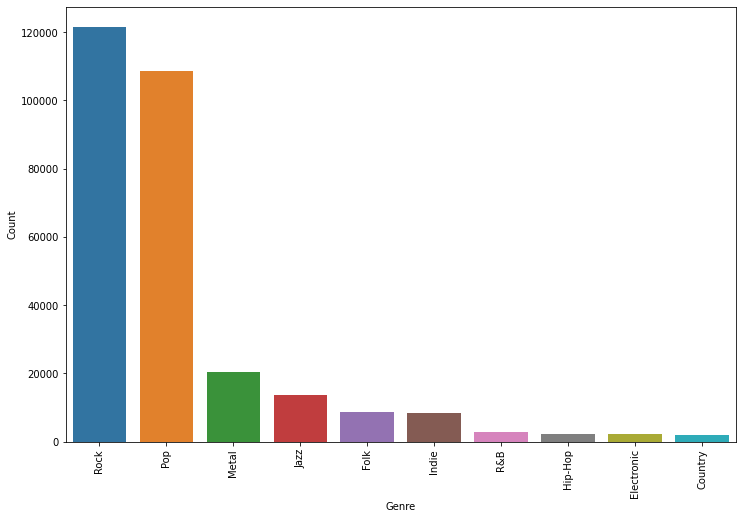

In [ ]:
plt.figure(figsize=(12,8))
counts = train_data.Genre.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90);

In [ ]:
num_words = 50000
max_len = 500
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
train_data["Lyrics"] = pd.concat([train_data['Lyrics']],axis=0).astype("str")
tokenizer.fit_on_texts(train_data['Lyrics'].values)

In [ ]:
X = tokenizer.texts_to_sequences(train_data['Lyrics'].values)
X = pad_sequences(X, maxlen=max_len)
Y = pd.get_dummies(train_data['Genre']).values

X_test = tokenizer.texts_to_sequences(test_data['Lyrics'].values)
X_test = pad_sequences(X_test, maxlen=max_len)
Y_test = pd.get_dummies(test_data['Genre']).values




In [ ]:
X.shape

(290183, 500)

In [ ]:
X_test.shape

(7935, 500)

RNN Variants

RNN model with LSTM

In [ ]:

model = Sequential()
model.add(Embedding(num_words, 100, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64,  return_sequences=True))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 4293, 100)         5000000   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 4293, 100)        0         
 lDropout1D)                                                     
                                                                 
 lstm_11 (LSTM)              (None, 4293, 64)          42240     
                                                                 
 dense_40 (Dense)            (None, 4293, 10)          650       
                                                                 
Total params: 5,042,890
Trainable params: 5,042,890
Non-trainable params: 0
_________________________________________________________________


In [ ]:
                         
model.fit(X, Y, epochs=6, batch_size=32,validation_data=(X_test,Y_test))

Epoch 1/6


ValueError: ignored

In [ ]:
results = model.evaluate(X_test, Y_test, verbose=1)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Multilayer LSTM

In [ ]:
EMBEDDING_DIM = 100

In [ ]:
model_m = Sequential()
model_m.add(Embedding(num_words, EMBEDDING_DIM, input_length=X.shape[1]))
model_m.add(SpatialDropout1D(0.2))
model_m.add(LSTM(64,  return_sequences=True))
model_m.add(LSTM(32))
model_m.add(Dense(10, activation='softmax'))
model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_m.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 500, 100)          5000000   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 500, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_12 (LSTM)              (None, 500, 64)           42240     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dense_43 (Dense)            (None, 10)                330       
                                                                 
Total params: 5,054,986
Trainable params: 5,054,986
Non-trainable params: 0
___________________________________________

In [ ]:
model_m.fit(X, Y, epochs=6, batch_size=32,validation_data=(X_test,Y_test))

Epoch 1/6
9069/9069 [==============================] - 303s 33ms/step - loss: 1.2035 - accuracy: 0.5816 - val_loss: 2.7909 - val_accuracy: 0.2662
Epoch 2/6
9069/9069 [==============================] - 303s 33ms/step - loss: 0.9708 - accuracy: 0.6719 - val_loss: 3.2937 - val_accuracy: 0.2838
Epoch 3/6
9069/9069 [==============================] - 306s 34ms/step - loss: 0.8410 - accuracy: 0.7153 - val_loss: 3.5584 - val_accuracy: 0.2886
Epoch 4/6
9069/9069 [==============================] - 306s 34ms/step - loss: 0.7408 - accuracy: 0.7498 - val_loss: 3.6187 - val_accuracy: 0.2880
Epoch 5/6
9069/9069 [==============================] - 301s 33ms/step - loss: 0.6505 - accuracy: 0.7814 - val_loss: 3.9180 - val_accuracy: 0.2912
Epoch 6/6
9069/9069 [==============================] - 307s 34ms/step - loss: 0.5719 - accuracy: 0.8091 - val_loss: 4.1662 - val_accuracy: 0.2920


In [ ]:
results = model_m.evaluate(X_test, Y_test, verbose=1)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

248/248 [==============================] - 4s 17ms/step - loss: 4.1662 - accuracy: 0.2920
    Test Loss: 4.16617
Test Accuracy: 29.20%


Basic RNN model 

In [ ]:
model_b = Sequential()
model_b.add(Embedding(num_words, EMBEDDING_DIM, input_length=X.shape[1]))
model_b.add(SpatialDropout1D(0.2))
model_b.add(SimpleRNN(64))
model_b.add(Dense(10, activation='softmax'))
model_b.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_b.summary()

In [ ]:
model_b.fit(X, Y, epochs=6, batch_size=32,validation_data=(X_test,Y_test))

In [ ]:
results = model_b.evaluate(X_test, Y_test, verbose=1)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

CNN

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu', input_shape=(X.shape[1],1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dense(10, activation='softmax'))
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_50 (Conv1D)          (None, 500, 128)          640       
                                                                 
 max_pooling1d_48 (MaxPoolin  (None, 250, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_51 (Conv1D)          (None, 250, 64)           32832     
                                                                 
 max_pooling1d_49 (MaxPoolin  (None, 125, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_52 (Conv1D)          (None, 125, 32)           8224      
                                                                 
 max_pooling1d_50 (MaxPoolin  (None, 62, 32)         

In [ ]:
model_cnn.fit(X, Y,
          epochs=6, 
          batch_size=32, 
          validation_data=(X_test,Y_test),
          verbose=1)

Epoch 1/6
9069/9069 [==============================] - 45s 5ms/step - loss: 1.9285 - accuracy: 0.4166 - val_loss: 3.0597 - val_accuracy: 0.1777
Epoch 2/6
9069/9069 [==============================] - 44s 5ms/step - loss: 1.4238 - accuracy: 0.4133 - val_loss: 3.0926 - val_accuracy: 0.1777
Epoch 3/6
9069/9069 [==============================] - 43s 5ms/step - loss: 1.4231 - accuracy: 0.4146 - val_loss: 3.0137 - val_accuracy: 0.1777
Epoch 4/6
9069/9069 [==============================] - 44s 5ms/step - loss: 1.4228 - accuracy: 0.4155 - val_loss: 3.0843 - val_accuracy: 0.1777
Epoch 5/6
9069/9069 [==============================] - 44s 5ms/step - loss: 1.4224 - accuracy: 0.4170 - val_loss: 3.0915 - val_accuracy: 0.1777
Epoch 6/6
9069/9069 [==============================] - 44s 5ms/step - loss: 1.4224 - accuracy: 0.4176 - val_loss: 3.1311 - val_accuracy: 0.1777


In [ ]:
scores = model_cnn.evaluate(X_test, Y_test, verbose=1)
print("    Test Loss: {:.5f}".format(scores[0]))
print("Test Accuracy: {:.2f}%".format(scores[1] * 100))

248/248 [==============================] - 1s 3ms/step - loss: 3.1311 - accuracy: 0.1777
    Test Loss: 3.13107
Test Accuracy: 17.77%


Random Forests

In [ ]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label='Genre')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label='Genre')


In [ ]:
# Specify the model.
model_1 = tfdf.keras.RandomForestModel()

# Train the model.
model_1.fit(x=train_ds)

# Optionally, add evaluation metrics.
model_1.compile(
    metrics=["accuracy"])

model_1.summary()

In [ ]:
# Train the model.

model_1.fit(x=train_ds, validation_data=test_ds)

In [ ]:
scores = model_1.evaluate(test_ds, return_dict=True)



for name, value in scores.items():
  print(f"{name}: {value:.4f}")

In [ ]:
model_cnn.save('/content/local/model_without_embedding.h5')

In [ ]:
model_m.save('/content/local/model_with_embedding.h5')